<a href="https://colab.research.google.com/github/James-Yuichi-Sato/fourth_brain_mlops_2021_june_cohort/blob/main/4B_Week_2_Offline_Fashion_MNIST_ML_Monitoring_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In this assignment, we will train and test Convolutional Neural Network Models for multi-class image classification using the Pytorch framework. 

##**Our focus is NOT on training the best ML model, but monitoring ML model performance for test/production data.**

Please focus on your learnings from the **Weights and Biases** platform here.
The intention here is to monitor the classification outcome for batches of production data using the **Weights and Biases** platform.

Sources:
* [1] https://colab.research.google.com/drive/1X99lDIZt6fM1DCNWA65xnr7dW6qNvxbh?usp=sharing
* [2] Blog https://towardsdatascience.com/logging-with-weights-biases-da048e3cbc8b
* [3]https://colab.research.google.com/github/kjamithash/Pytorch_DeepLearning_Experiments/blob/master/FashionMNIST_ResNet_TransferLearning.ipynb#scrollTo=kSa1Bg3722Gz

## **Description of this Project**:  In this assignment, we are given the Fashion MNIST data set (https://www.kaggle.com/zalando-research/fashionmnist) with 60k training images and 10k test images, such that each image can be categorized as one of 10 output clothing categories. Our project demands the following:


---


##1. Train an off the shelf/simple image classifier and monitor the training process.
##2. Monitor the test sample batches for pre-production testing (ML Monitoring) to detect drifts in the production data.


---



# **Task 0**: Getting to know the data
Lets begin by loading the libraries and the data set.

In [1]:
import time

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Step 1: Since we will monitor the ML model training and production testing using Weights and Biases, create an account at https://wandb.ai and login. 
In the same browser launch this colab so authentication is automaticaly done.


In [2]:
%pip install wandb -q
import wandb

     |████████████████████████████████| 1.8MB 8.3MB/s 
     |████████████████████████████████| 133kB 52.2MB/s 
     |████████████████████████████████| 102kB 12.5MB/s 
     |████████████████████████████████| 174kB 48.4MB/s 
     |████████████████████████████████| 71kB 11.9MB/s 


In [3]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Step 2: Generate the Datasets and Dataloaders

len() function is used to calculate size of an object in python. For more information on len() see https://docs.python.org/3/library/functions.html#len

In [4]:
# Define transforms for data preprocessing
transform = transforms.Compose([
    transforms.ToTensor()
])

# Datasets
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Dataloaders to feed the data in batches
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1000, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=True, num_workers=4)
prodloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=True)

# Print the number of train images, test images, train batches and test batches using len function discussed earlier. 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten

DataLoaders are used to load data in batches. 

# **Task 1**: Create a simple CNN model using Pytorch. You are NOT Required to learn the nitty gritty of a Pytorch CNN model, just use the code below as a sample codeblock for future assignments.

nn.Module is the bast class used for all neural network modules. Following is a CNN for FashionMNIST classification. 
(optional) For information on how nn.Module works see https://pytorch.org/docs/stable/generated/torch.nn.Module.html 
(optional) Fonr information on how layers in pytorch work see https://pytorch.org/docs/stable/nn.html

In [5]:
#Sample Pytorch Code#############################
class Network(nn.Module):
    
    def __init__(self):
        super(Network, self).__init__()
    
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.fc1 = nn.Linear(12 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.reshape(-1, 12 * 4 * 4)
        
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        
        x = self.fc3(x)
        return x

## Next, lets declare some Helper Functions

find_acc function is used to calculate accuracy for the predictions and labels using the argmax function for 1st axis. train function is used to train the created model with the training data in the trainloader batch. validate function calculates the loss and accuracy for the test set. count_outcomes function calculates the number of outcomes in a given batch.  

In [6]:
def find_acc(pred, label):
    """pixelwise accuracy"""
    correct = pred.argmax(dim = 1).eq(label)
    accuracy = correct.to(torch.float32).mean().item() * 100
    return accuracy

def train(network, epoch, criterion, optimizer, trainloader):
    loss_train = 0
    acc_train = 0
    network.train()
    
    for step in range(len(trainloader)):

        images , labels = next(iter(trainloader))
        
        # move the images and labels to GPU
        images = images.to(device)
        labels = labels.to(device)
        
        pred = network(images)
        
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
        loss_train_step = criterion(pred , labels)
        
        # find accuracy
        acc_train_step = find_acc(pred, labels)
        
        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        
        loss_train += loss_train_step.item()
        acc_train += acc_train_step  
            
        loss_train /= len(trainloader)
        acc_train /= len(testloader)

        return loss_train, acc_train  
        
def validate(network, epoch, criterion, testloader): 
    loss_valid = 0
    acc_valid = 0       
    network.eval()  

    for step in range(len(testloader)):

        images , labels = next(iter(testloader))
        
        # move the images and labels to GPU
        images = images.to(device)
        labels = labels.to(device)
        
        pred = network(images)
        
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss and acc for the current step
        loss_valid_step = criterion(pred , labels)
        acc_valid_step = find_acc(pred, labels)
      
        loss_valid += loss_valid_step.item()
        acc_valid += acc_valid_step

        loss_valid /= len(trainloader)
        acc_valid /= len(testloader)

        return loss_valid, acc_valid



def count_outcomes(arr):
  res=np.zeros(10)
  for x in range(10):
    for i in range(len(arr)):
        if x == arr[i]:
            res[x]=res[x]+1
  return res

#**Task 2**: Train the simple CNN Network and watch the model logs at the **Weights and Biases** portal.

In [7]:
# Initialize WandB 

# Set an experiment name to group training and evaluation
experiment_name = wandb.util.generate_id()

wandb.init(project="intro-demo",
           group=experiment_name,
           notes='This is the first run', 
           tags=['Fashion MNIST', 'Test Run'])

# WandB Configurations (optional)        
wandb.config.lr = 0.01    

network = Network().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), wandb.config.lr)

# Log the network weight histograms (optional)
wandb.watch(network)

num_epochs = 100
start_time = time.time()
for epoch in range(1, num_epochs+1):
    
    loss_train, acc_train = train(network, epoch, criterion, optimizer, trainloader)
    loss_valid, acc_valid = validate(network, epoch, criterion, testloader)
    
    #Print the epoch number, training loss, training accuracy, validation loss and validation accuracy for each epoch


    # Log the loss and accuracy values at the end of each epoch
    wandb.log({
        "Epoch": epoch,
        "Train Loss": loss_train,
        "Train Acc": acc_train,
        "Valid Loss": loss_valid,
        "Valid Acc": acc_valid})

# Print the time taken for training the data. It can be calculated using the difference between current time and start time. 
# Current time can be retrieved using time.time()
end_time = time.time()

elapsed_time = end_time - start_time

print('Time Elapsed: ' + str(elapsed_time) + 's')


wandb: Currently logged in as: jamesysato (use `wandb login --relogin` to force relogin)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Time Elapsed: 86.69255948066711s


# Attach snapshot of your **Weights and Biases** plot here! Add a few lines of your findings so far...
## Next, predict on Test Dataset..

In [8]:
def test_model(model):

    start_time = time.time()

    num_correct = 0
    accuracy = 0

    with torch.no_grad():

        for batch in testloader:

            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)

            total_images = len(testset)

            pred = model(images)

            num_correct_batch = pred.argmax(dim = 1).eq(labels).sum().item()

            accuracy_batch = pred.argmax(dim = 1).eq(labels).float().mean().item()

            num_correct += num_correct_batch
            accuracy += accuracy_batch

        accuracy /= len(testloader)

    # Stop the timer at the end of the testing iterations and calculate elapsed time
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Print the number of test images, correct predictions and accuracy for the test dataset.
    print('Number of test images: ' + str(total_images))
    print('Number of correct predictions: ' + str(num_correct))
    print('Accuracy: ' + str(accuracy))

    # Print the time taken for predicting the data. It can be calculated using the difference between current time and start time. 
    print('Time Elapsed: ' + str(elapsed_time) + 's')
    
    # Current time can be retrieved using time.time()
    
# test the trained network    
test_model(network)    

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Number of test images: 10000
Number of correct predictions: 8068
Accuracy: 0.8067999815940857
Time Elapsed: 1.091585397720337s


# Now you know how to train and test a CNN model for image classification!

# **Task 3**: Transfer Learning. To leverage pre-trained models, we will now declare a new Network that is pre-trained (Resnet50).
## Your task here is to train this new network and monitor the training process on **Weights and Biases** as in Task 2.


In [9]:
# Start here###########################
import torchvision
import torchvision.models as models
from torchvision import transforms
import time
from tqdm.autonotebook import tqdm
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect

import matplotlib.pyplot as plt
import numpy as np

In [10]:
class MnistResNet(nn.Module):
  def __init__(self, in_channels=1):
    super(MnistResNet, self).__init__()

    # Load a pretrained resnet model from torchvision.models in Pytorch
    self.model = models.resnet50(pretrained=True)

    # Change the input layer to take Grayscale image, instead of RGB images. 
    # Hence in_channels is set as 1 or 3 respectively
    # original definition of the first layer on the ResNet class
    # self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    
    # Change the output layer to output 10 classes instead of 1000 classes
    num_ftrs = self.model.fc.in_features
    self.model.fc = nn.Linear(num_ftrs, 10)

  def forward(self, x):
    return self.model(x)




## Next, initialize **Weights and Biases** as you did in Task 2 to train and test the fine-tuned version of Resnet50.

We are going to log the output in Weights and Biases. For more information on how to log in Weights and Biases see https://docs.wandb.ai/ref/python/log

In [11]:
# Initialize WandB 
# Set an experiment name to group training and evaluation
experiment_name = wandb.util.generate_id()

wandb.init(project="intro-demo",
           group=experiment_name,
           notes='This is a second run', 
           tags=['Fashion MNIST', 'Test Run'])

network = MnistResNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr=3e-4)

# Log the network weight histograms (optional)
wandb.watch(network)

num_epochs = 100
start_time = time.time()
for epoch in range(1, num_epochs+1):
    
    loss_train, acc_train = train(network, epoch, criterion, optimizer, trainloader)
    loss_valid, acc_valid = validate(network, epoch, criterion, testloader)
    
    #Print the epoch number, training loss, training accuracy, validation loss and validation accuracy for each epoch
    print('Epoch: ' + str(epoch) + '  Train Loss: '  + str(loss_train) + '  Train Acc: ' + str(acc_train) + '  Valid Loss: ' + str(loss_valid) + '  Valid Acc: ' + str(acc_valid))

    # Log the loss and accuracy values at the end of each epoch
    # ADD THE LOGING CODE HERE BY REFERING THE LINK PROVIDED
    wandb.log(
        {'Epoch': epoch, 'Train Loss': loss_train, 'Train Accuracy': acc_train, 'Valid Loss': loss_valid, 'Valid Accuracy': acc_valid},
        step = epoch
    )

# Print the time taken for training the data. It can be calculated using the difference between current time and start time. 
end_time = time.time()
elapsed_time = end_time - start_time

print('Time Elapsed: ' + str(elapsed_time) + 's')
# Current time can be retrieved using time.time()

Epoch,100
Train Loss,0.00844
Train Acc,0.82
Valid Loss,0.01066
Valid Acc,0.72
_runtime,101
_timestamp,1625427038
_step,99


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train Loss,███▆▅▄▃▃▃▂▂▂▂▂▂▂▂▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Acc,▁▂▁▃▅▅▆▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇█████████████
Valid Loss,█▇▆▆▄▄▃▄▃▃▃▃▂▂▃▂▂▂▂▂▁▂▁▂▂▂▃▂▂▂▂▂▁▁▁▁▁▁▁▂
Valid Acc,▁▃▄▄▅▅▅▅▆▅▇▆▇▇▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█▇█▇▇
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 1  Train Loss: 0.03933259646097819  Train Acc: 0.10300000756978989  Valid Loss: 0.04585845073064168  Valid Acc: 0.12999999523162842
Epoch: 2  Train Loss: 0.03529128630956014  Train Acc: 0.2980000078678131  Valid Loss: 0.04373374382654826  Valid Acc: 0.11999999731779099
Epoch: 3  Train Loss: 0.027272194623947144  Train Acc: 0.5490000247955322  Valid Loss: 0.04321106274922689  Valid Acc: 0.10999999940395355
Epoch: 4  Train Loss: 0.019932506481806438  Train Acc: 0.6730000376701355  Valid Loss: 0.04287647008895874  Valid Acc: 0.07999999821186066
Epoch: 5  Train Loss: 0.014815449714660645  Train Acc: 0.7290000319480896  Valid Loss: 0.03922098477681478  Valid Acc: 0.10999999940395355
Epoch: 6  Train Loss: 0.01318968137105306  Train Acc: 0.7320000529289246  Valid Loss: 0.0422603448232015  Valid Acc: 0.09999999403953552
Epoch: 7  Train Loss: 0.011914106210072835  Train Acc: 0.7470000386238098  Valid Loss: 0.04125805695851644  Valid Acc: 0.08999999612569809
Epoch: 8  Train Loss: 0.010342

# Now, lets visualize some of the predictions


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


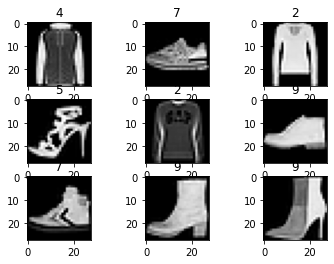

In [12]:
for batch in testloader:
    images, labels = batch
    for i in range(0, 9):
            plt.subplot(330+1 + i)
            plt.imshow(np.reshape(images[i],(28,28)), cmap=plt.get_cmap('gray'))
            plt.title(np.array(labels[i]))

    plt.show()
    break

# **Task 4**: Now that we have trained two CNN models, we need to monitor their progress on production data.

## Notice that at production time, you dont have access to groundtruth (i.e. actual labels). Lets answer these questions first! Write the answers to these questions below.
## Q1: **What could be some metrics that you monitor at production time?** Think about data and concept drift that needs to be monitored.

We could measure the output ratio from the model and check to see if there was drifts from the training-time dataset ratio, which could indicate drift in the dataset. We could also look into the model outputs before the final fully connected layers and compare the model output averages at that point with the same point in the model with the training-time data to see if data features in production are as strongly activating the final layer as the training set, which could indicate drift.

## Q2: If you had data flow **in batches**, as opposed to individual samples, **what would your metrics to be monitored be**?

We could compare the output metrics per batch like explained in question 1. We could pair output ratios from the batches on average and compare it to that during train time to help indicate drift. Same for measuring metrics before the fully connected layer.

--------------------------------------------------------------------------------

## **HINTS**: 
### 1. Think of data in batches of 10 (since 10 classes equally likely for data distribution here). Now, if the distribution of data in batches of 10 changes from uniform to something else that that would mean **DATA DRIFT**. So you could count the number of predicted samples per class and use that as a metric to identify Data Drift.
###2. Model output is always probabilistic. So if the range of probabilities (max prob and mean prob) shifts across batches, that can mean a certain degree of concept drift.


## Now that you have an idea of some prodction metrics you need to mobitor, initialize a new **Weights and Biases** Run and monitor the metrics for some epochs.

We are going to log the output in Weights and Biases. For more information on how to log in Weights and Biases see https://docs.wandb.ai/ref/python/log

# Please remember to start a NEW RUN to log your data or else you will NOT be able to infer from the plots.

In [13]:
experiment_name = wandb.util.generate_id()
wandb.init(project="intro-demo",
           group=experiment_name,
           notes='This is Test Run', 
           tags=['Fashion MNIST', 'Production'])



num_epochs = 30

for epoch in range(1, num_epochs+1):
  #Next lets declare the metrics to monitor at production time
  # Initialize all the matrics that we are goint to monitor here. 
  # Initialize accuracy, number of correct predictions, start time, minimum batch output, maximum batch output and number of batches here. 
  # NOTE: Current time can be calculated using time.time() function. Here, the start_time would be current time.
  accuracy = num_correct = num_batches = total_images = 0
  min_batch_op = max_batch_op = []
  start_time = time.time()

  print(epoch)

  ##### Write code to monitor the metrics you decided at run time###########

  for batch in prodloader: # Consider a batch of 10 images at a time
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)
    # We are trying to calculate the total number of images for the test. 
    # ADD YOUR CODE TO CALCULATE TOTAL NUMBER OF IMAGES IN THE TEST SET
    total_images += len(images)

    # We are going to get the predictions for the images from the network here.
    # ADD YOUR CODE TO PASS IMAGES PER BATCH TO THE NETWORK HERE
    pred = network(images)

    pred_batch=sorted(pred.argmax(dim=1).cpu().numpy())

    # We are going to calculate the number of outcomes for each prediction batch using count_outcomes function declared earlier.
    #ADD YOUR CODE HERE TO COUNT THE NUMBER OF OUTCOMES USING count_outcomes FOR prediction batch HERE
    
    num_batch = sum(count_outcomes(pred_batch))

    num_batches=num_batches+num_batch
    num_correct_batch = pred.argmax(dim = 1).eq(labels).sum().item()
    accuracy_batch = pred.argmax(dim = 1).eq(labels).float().mean().item()
    num_correct +=num_correct_batch
    accuracy += accuracy_batch
    max_val=np.max(pred.max(dim=1).values.cpu().detach().numpy())
    min_val=np.min(pred.min(dim=1).values.cpu().detach().numpy())
    max_batch_op.append(max_val)
    min_batch_op.append(min_val)
 
  # The batch time for each batch would be the difference between current time and start time.
  # ADD YOUR CODE TO CALCULATE batch_time HERE
  batch_time = time.time() - start_time

  # print(num_correct, accuracy/len(prodloader), batch_time, num_batches, max(max_batch_op),min(min_batch_op))
  
  # Log the metrics defined earlier 
    # ADD THE LOGING CODE FOR METRICS HERE BY REFERING THE LINK PROVIDED
    # THE VALUES THAT WE ARE LOGING ARE batch time, number of correct predictions, batch accuracy, maximum batch output, minimum batch output, number of predictions for each batch.
  wandb.log(
        {'Epoch Time': batch_time, 'Number of Correct Predictions': num_correct, 'Epoch Accuracy': accuracy, 'Max Epoch Output': max(max_batch_op), 'Min Epoch Output': min(min_batch_op), 'Number of Predictions': num_batches}
  )
 


Epoch,100
Train Loss,0.00374
Train Accuracy,0.905
Valid Loss,0.00527
Valid Accuracy,0.94
_runtime,178
_timestamp,1625427220
_step,100


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train Loss,█▆▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▅▆▇▇▇▇▇▇▇▇▇▇████▇██████████████████████
Valid Loss,██▇▇▇▆▅▄▄▄▄▃▃▃▃▂▃▃▂▂▂▂▂▁▂▁▂▁▁▁▂▁▂▁▂▂▁▁▂▁
Valid Accuracy,▁▁▁▁▂▂▃▄▄▅▅▅▆▆▆▇▆▆▇▇▆▇▇█▇▇▇█████▇██▇██▇█
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


# **Task 5**: Lets modify the production data, using augmentation techniques and observe the model metrics with the augmented data. 
This will give an idea about how "drft" occurs in ML model. The goal is to identify is the drift between input and output (concept drift) or because of the data (data drift).

In [14]:
transformations = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.RandomCrop((28,28), fill=0, padding_mode='constant'),
    transforms.RandomHorizontalFlip(),
    transforms.RandomErasing(p=1),
    transforms.RandomRotation(180)
])


## Lets visualize the image transformations. Run the cell underneath a few times and observe the transformations.

Matplotlib is used to display the images. We are going to use imshow to display the images after reshaping them in (28,28) size. And then we will add title to images to have more information about them. For information on imshow() see https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html. 
For more information on title() see https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.title.html 
To reshape the image, we will use reshape function from numpy. 
For more information on reshape, see https://numpy.org/doc/stable/reference/generated/numpy.reshape.html

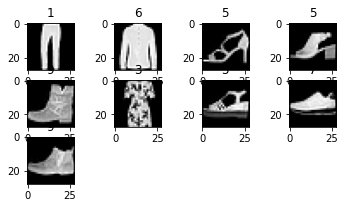

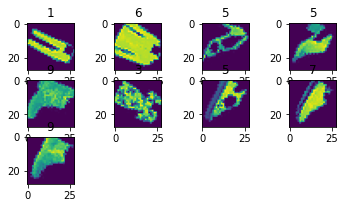

In [15]:
#Run 3-5 times

# We are going to visualize various images with their transformed images.  

for batch in prodloader: # Consider a batch of 10 images at a time
    images, labels = batch

    #Lets get an idea of the 
    plt.subplot(450+1)
    # reshape the actual image to (28,28) dimension using the link provided.
    # ADD YOUR CODE TO RESHAPE THE ACTUAL IMAGE HERE
    red_images = np.reshape(images, (len(images), 28, 28))

    # Plot the actual image from the batch using imshow using the link provided
    # ADD YOUR ACTUAL IMAGE PLOT CODE HERE
    for i in range(0, len(red_images)-1):
        plt.subplot(440+1 + i)
        plt.imshow(red_images[i], cmap=plt.get_cmap('gray'))
        plt.title(np.array(labels[i]))
    plt.show()
    

    # Transform the images by passing them to transformations function above
    # ADD YOUR CODE TO PASS THE IMAGE TO THE transformations function AND GET THE TRANSFORMED IMAGE HERE
    plt.subplot(450+1+1)
    tran_images = transformations(images)

    # reshape the reformed image to (28,28) dimension using the link provided.
    # ADD YOUR CODE TO RESHAPE THE TRANSFORMED IMAGE HERE
    red_tran_images = np.reshape(tran_images, (len(tran_images), 28, 28))

    # Plot the transformed image from the batch using imshow using the link provided
    # ADD YOUR TRANSFORMED IMAGE PLOT CODE HERE
    for i in range(0, len(red_images)-1):
        plt.subplot(440+1 + i)
        plt.imshow(red_tran_images[i])
        plt.title(np.array(labels[i]))
    plt.show()
    break


We are going to log the output in Weights and Biases. For more information on how to log in Weights and Biases see https://docs.wandb.ai/ref/python/log

In [16]:
num_epochs = 30

for epoch in range(1, num_epochs+1):
  #Next lets declare the metrics to monitor at production time
  # Initialize all the matrics that we are goint to monitor here. 
  # Initialize accuracy, number of correct predictions, start time, minimum batch output, maximum batch output and number of batches here. 
  # NOTE: Current time can be calculated using time.time() function. Here, the start_time would be current time.
  accuracy = num_correct = num_batches = total_images = 0
  min_batch_op = max_batch_op = []
  start_time = time.time()

  print(epoch)


  ## Monitor the same metrics in Task 4 with augenmented test data
  for batch in prodloader: # Consider a batch of 10 images at a time
    images, labels = batch
    images=transformations(images)    
    images = images.to(device)
    labels = labels.to(device)
    # We are trying to calculate the total number of images for the test. 
    # ADD YOUR CODE TO CALCULATE TOTAL NUMBER OF IMAGES IN THE TEST SET
    total_images += len(images)

    # We are going to get the predictions for the images from the network here.
    # ADD YOUR CODE TO PASS IMAGES PER BATCH TO THE NETWORK HERE
    pred = network(images)

    pred_batch=sorted(pred.argmax(dim=1).cpu().numpy())

    # We are going to calculate the number of outcomes for each prediction batch using count_outcomes function declared earlier.
    #ADD YOUR CODE HERE TO COUNT THE NUMBER OF OUTCOMES USING count_outcomes FOR prediction batch HERE
    num_batch = sum(count_outcomes(pred_batch))
    
    num_batches=num_batches+num_batch
    num_correct_batch = pred.argmax(dim = 1).eq(labels).sum().item()
    accuracy_batch = pred.argmax(dim = 1).eq(labels).float().mean().item()
    num_correct +=num_correct_batch
    accuracy += accuracy_batch
    max_val=np.max(pred.max(dim=1).values.cpu().detach().numpy())
    min_val=np.min(pred.min(dim=1).values.cpu().detach().numpy())
    max_batch_op.append(max_val)
    min_batch_op.append(min_val)
 
  batch_time=time.time() - start_time
  #print(num_correct, accuracy/len(prodloader), batch_time, num_batches, max(max_batch_op),min(min_batch_op))


  
  # Log the metrics defined earlier 
    # ADD THE LOGING CODE FOR METRICS HERE BY REFERING THE LINK PROVIDED
    # THE VALUES THAT WE ARE LOGING ARE batch time, number of current predictions, batch accuracy, maximum batch output, minimum batch output, number of predictions for each batch.
  wandb.log(
        {'Epoch Time': batch_time, 'Number of Correct Predictions': num_correct, 'Epoch Accuracy': accuracy, 'Max Epoch Output': max(max_batch_op), 'Min Epoch Output': min(min_batch_op), 'Number of Predictions': num_batches}
  )

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


# Notice how the monitoring curves have changed, thus showing that there is a drift and two follow ups should happen:
* ML model must be retrained with the transformed images
* If an ML model is trained with upright images only, checks must be done at run-time to prevent transformed images to be applied as test data.

## Summarize all your findings below and think of how you will devise production-time metrics.

With classifier problems, it is arithmetically simple to calculate metrics that would help us keep track of data and concept skew. Using rolling average outputs during production-time on metrics such as prediction latency, minimum and maximum outputs, output ratio over time, and downstream prediction accuracy/click-through metrics could indicate to us when we are experiencing data and concept skew.

It appears silly that many AI systems might not be producing enough training time metrics to compare to production metrics. It makes sense to me that a successful MLOps team would standardize performance metrics early on to ensure that we can generate comparative metrics at training time. Building this into software development standards for the ML workflow will ensure that even an overloaded MLOps team would be able to promptly check model performance and prioritize most severe cases over minimal skew.